In [6]:
!pip install scipy==1.1.0 pillow imagehash distance

     |████████████████████████████████| 31.2 MB 58 kB/s 
     |████████████████████████████████| 812 kB 46.3 MB/s 
     |████████████████████████████████| 180 kB 51.1 MB/s 
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=906318598669a313643106e05b16058befafe304030f40fe9746d8bc612d5760
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=09c64263ea63b7ff77b7be2d706211035272ea2528d3f63453fbc035906797ee
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built imagehash distance
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

In [53]:
%%writefile duplicate_images_remover.py
import os
from PIL import Image
import distance
import re
import numpy as np
from imagehash import dhash
from numpy import array
import cv2
import math
from google.colab.patches import cv2_imshow
import argparse
import warnings
warnings.filterwarnings('ignore')

valid_images = (".jpg",".gif",".png",".tga")
_nsre = re.compile('([0-9]+)')

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)] 


def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        

def image_file_count(path, info):
  for index, filename in  enumerate(sorted(os.listdir(path), key=natural_sort_key)):  
    if filename.endswith(valid_images) and info == True:
      print(filename)

  return index+1

def grayimage_file2hash(path, info):
  hashes = {}
  imghashes =[]
  imgpaths = []
  for index, filename in  enumerate(sorted(os.listdir(path), key=natural_sort_key)):  
    if filename.endswith(valid_images):
      filepath = os.path.join(path,filename)
      imgpaths.append(filepath) 
      img = Image.open(filepath)
      img = img.resize((100,100))
      x = img.convert('L') #makes it grayscale
      dhash1 = dhash(x)  
      
      p = hashes.get(dhash1, [])
      p.append(filepath)
      hashes[dhash1] = p
      imghashes.append(str(dhash1))
      if info == True:
        print("dHash: ",index, filename,"-->",dhash1)

  return index+1, imghashes, imgpaths 


def isgray(path):
    img = cv2.imread(path)
    if len(img.shape) < 3: return True
    if img.shape[2]  == 1: return True
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    
    return False


def pixel_brightness(pixel):
    assert 3 == len(pixel)
    r, g, b = pixel
    return math.sqrt(0.299 * r ** 2 + 0.587 * g ** 2 + 0.114 * b ** 2)


def image_brightness(img):
    nr_of_pixels = len(img) * len(img[0])
    s = 0
    for row in img:
      for pixel in row:
        s += pixel_brightness(pixel)
    return s / nr_of_pixels


def duplicate_images_remover(imghashes, imgpaths):
  # loop over the image hashes
  visited = []
  th = int(args["threshold"])
  for i, imhase1 in enumerate(imghashes):
    a = imhase1
    montage = None
    z = np.inf
    fg = 0
    for j, imhase2 in enumerate(imghashes):  
      if i != j and i not in visited:
        p = imgpaths[i]
        image1 = cv2.imread(p)
        w1, h1, c1 = image1.shape
        image1 = cv2.resize(image1, (150, 150))
        bright1 = image_brightness(image1)
        image1 = cv2.putText(image1,str(h1)+"x"+str(w1), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 2)
        if isgray(p):
          image1 = cv2.putText(image1,"gray", (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2, cv2.LINE_AA)
        else:
          image1 = cv2.putText(image1,"color", (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2, cv2.LINE_AA)       

        if montage is None:
          montage = image1
        
        b = imhase2 
        z = distance.hamming(a, b)
      
        # loop over all image paths with the same hash
        if z <= th:
          #print(z)
          visited.append(j)
          # load the input image and resize it to a fixed width
          # and heightG
          q = imgpaths[j]
          image2 = cv2.imread(q)
          w2, h2, c2 = image2.shape
          image2 = cv2.resize(image2, (150, 150))
          bright2 = image_brightness(image2)
          image2 = cv2.putText(image2,str(h2)+"x"+str(w2), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 2)
          if isgray(q):
            image2 = cv2.putText(image2,"gray", (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2, cv2.LINE_AA)
          else:
            image2 = cv2.putText(image2,"color", (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2, cv2.LINE_AA)
            if bright2 > bright1:
              image2 = cv2.putText(image2,"brighter", (10,140), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2, cv2.LINE_AA)
            else:
              image2 = cv2.putText(image2,"darker", (10,140), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,144,30), 2, cv2.LINE_AA)
          
          image2 = cv2.putText(image2, "X", (120,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3, cv2.LINE_AA)
          # if our montage is None, initialize it
          montage = np.hstack([montage, image2])
          os.remove(imgpaths[j])
          fg = 1
    
    if fg == 1:
      # show the montage for the hash
      print("[INFO] hash: {}".format(imhase1))
      cv2_imshow(montage)


def delete_image_folder(path, info):
  rem = 0
  # Remove the specified  
  # file path 
  try: 
    for index, filename in  enumerate(sorted(os.listdir(path), key=natural_sort_key)):  
      if filename.endswith(valid_images):
        filepath = os.path.join(path,filename)
        if info == True:
          print(filepath)
        os.remove(filepath)
        rem += 1

    os.rmdir(path.split('/content/')[1]) 
  except OSError as error: 
      print(error) 
      print("Folder can not be removed") 

  return rem

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--folder", required=True,
	help="path to input image folder to be processed")
ap.add_argument("-t", "--threshold", required=True,
	help="hamming distance threshold value")
ap.add_argument("-i", "--info", type=str2bool, required=True,
	help="print all details or not")
args = vars(ap.parse_args())

total_imgs = image_file_count(args["folder"], False) 
print("Total Images: ", image_file_count(args["folder"], args["info"]))
hash_no, imghashes, imgpaths = grayimage_file2hash(args["folder"], args["info"])
print("Total Images Converted to Hash: ", hash_no)
duplicate_images_remover(imghashes, imgpaths)
print("Remaining Images: ", image_file_count(args["folder"], args["info"]))
deleted_imgs = delete_image_folder(args["folder"], args["info"])
print("Deleted: ", total_imgs - deleted_imgs)

Overwriting duplicate_images_remover.py


In [57]:
!unzip "/content/duplicates.zip" 

Archive:  /content/duplicates.zip
   creating: duplicates/
  inflating: duplicates/cat.1.jpg    
  inflating: duplicates/cat.10.jpg   
  inflating: duplicates/cat.11.jpg   
  inflating: duplicates/cat.13.jpg   
  inflating: duplicates/cat.14.jpg   
  inflating: duplicates/cat.141.jpg  
  inflating: duplicates/cat.144.jpg  
  inflating: duplicates/cat.2.jpg    
  inflating: duplicates/cat.38.jpg   
  inflating: duplicates/dog.101.jpg  
  inflating: duplicates/dog.23.jpg   
  inflating: duplicates/dog.24.jpg   
  inflating: duplicates/dog.245.jpg  
  inflating: duplicates/dog.4.jpg    
  inflating: duplicates/dog.86.jpg   
  inflating: duplicates/dog.86.png   


In [58]:
ls -l duplicates/*.jpg duplicates/*.png | wc -l  #count total image files with .jpg and .png

16


Total Images:  16
Total Images Converted to Hash:  16
[INFO] hash: f1d9d9e1e0e1e961


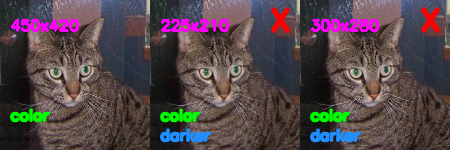

[INFO] hash: 741c5c68b89cf8f4


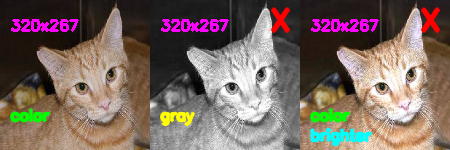

[INFO] hash: e9f135fcd89de1e3


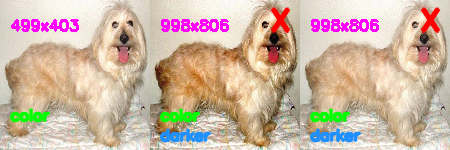

[INFO] hash: e0e6e6e6a8f898f0


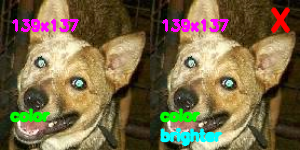

Remaining Images:  9
Deleted:  7
CPU times: user 51 s, sys: 246 ms, total: 51.2 s
Wall time: 51.2 s


In [56]:
%%time
%run duplicate_images_remover.py -f /content/duplicates -t 2 -i false

cat.1.jpg
cat.2.jpg
cat.10.jpg
cat.11.jpg
cat.13.jpg
cat.14.jpg
cat.38.jpg
cat.141.jpg
cat.144.jpg
dog.4.jpg
dog.23.jpg
dog.24.jpg
dog.86.jpg
dog.86.png
dog.101.jpg
dog.245.jpg
Total Images:  16
dHash:  0 cat.1.jpg --> f1d9d9e1e0e1e961
dHash:  1 cat.2.jpg --> 2a1b797031b01830
dHash:  2 cat.10.jpg --> f1d9d9e1e0e1e961
dHash:  3 cat.11.jpg --> f1d9d9e1e0e1e961
dHash:  4 cat.13.jpg --> 68c8c898f8d9dcd8
dHash:  5 cat.14.jpg --> 741c5c68b89cf8f4
dHash:  6 cat.38.jpg --> 0999d8e6d4d0e972
dHash:  7 cat.141.jpg --> 541c5c68b8bcf8f4
dHash:  8 cat.144.jpg --> 541c5c68b89cf8f4
dHash:  9 dog.4.jpg --> 09b8924eeaeb67ec
dHash:  10 dog.23.jpg --> e9f135fcd89de1e3
dHash:  11 dog.24.jpg --> e9f135fcd89de1e3
dHash:  12 dog.86.jpg --> e0e6e6e6a8f898f0
dHash:  13 dog.86.png --> e0e6e6e6a8f898f0
dHash:  14 dog.101.jpg --> 613331111d0f1b13
dHash:  15 dog.245.jpg --> e9f1357cd89de1e3
Total Images Converted to Hash:  16
[INFO] hash: f1d9d9e1e0e1e961


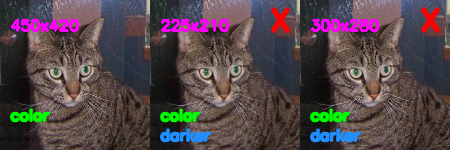

[INFO] hash: 741c5c68b89cf8f4


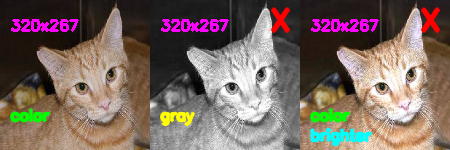

[INFO] hash: e9f135fcd89de1e3


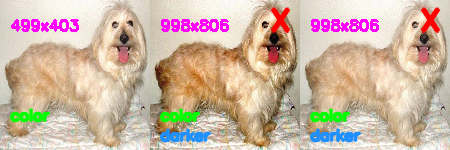

[INFO] hash: e0e6e6e6a8f898f0


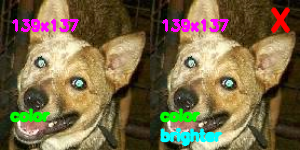

cat.1.jpg
cat.2.jpg
cat.13.jpg
cat.14.jpg
cat.38.jpg
dog.4.jpg
dog.23.jpg
dog.86.jpg
dog.101.jpg
Remaining Images:  9
/content/duplicates/cat.1.jpg
/content/duplicates/cat.2.jpg
/content/duplicates/cat.13.jpg
/content/duplicates/cat.14.jpg
/content/duplicates/cat.38.jpg
/content/duplicates/dog.4.jpg
/content/duplicates/dog.23.jpg
/content/duplicates/dog.86.jpg
/content/duplicates/dog.101.jpg
Deleted:  7
CPU times: user 51.8 s, sys: 251 ms, total: 52 s
Wall time: 52 s


In [59]:
%%time
%run duplicate_images_remover.py -f /content/duplicates -t 2 -i yes